#  Importing Libraries and Reading Data

In [65]:
# Importing Libraries

import pandas as pd # Data manipulation
import numpy as np # Matrix calculation
import geopandas as gpd # GIS of Pandas
import seaborn as sns # Part of matplotlib for Data Viz
import matplotlib.pyplot as plt # Data visualization

In [66]:
# Reading 2000-2023 Aggregated Yield Data
df_agg_00_23=pd.read_csv('data/rm_yield_00_23_major_crops.csv')

# Reading GIS
gdf_rm=gpd.read_file('data/RuralMunicipality.shp')

# Changing data type 
gdf_rm['RMNO']=gdf_rm['RMNO'].astype(int)
gdf_rm_clean=gdf_rm[['RMNO', 'geometry']].rename(columns={'RMNO': 'RM'})

### Data Cleaning and Preparation

In [67]:
# Ensure 'RM' columns are strings
df_agg_00_23['RM'] = df_agg_00_23['RM'].astype(str)
gdf_rm_clean['RM'] = gdf_rm_clean['RM'].astype(str)

# Cleaning function for RM column
def clean_rm_column(df):
    df['RM'] = df['RM'].str.strip().str.title()
    return df

# Apply the cleaning function to both dataframes
df_agg_00_23 = clean_rm_column(df_agg_00_23)
gdf_rm_clean = clean_rm_column(gdf_rm_clean)


### Merging Data Frames

In [68]:
# Merge the cleaned dataframes on 'RM'
merged_data = gdf_rm_clean.merge(df_agg_00_23, on='RM', how='left')

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Save merged data for future use
gdf.to_file('merged_data.geojson', driver='GeoJSON')


In [69]:
#Testing code
#print(merged_data.columns)
#print(df_agg_00_23.columns)

## Part 1: Regular Analysis of Canola and Wheat Yields

### Trend Analysis (Reshaping Data for Trend Analysis)

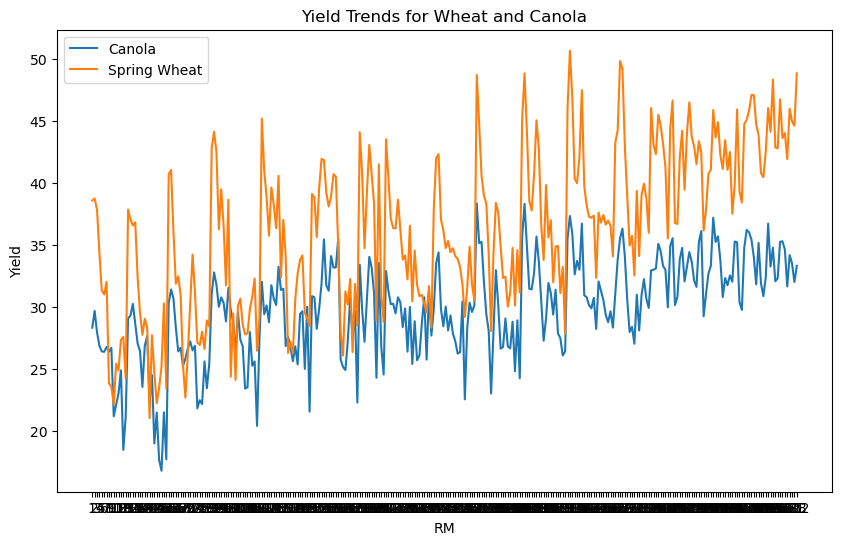

In [70]:
# Melt the dataframe to a long format for trend analysis
melted_df = df_agg_00_23.melt(id_vars=['RM'], 
                              value_vars=['Canola_mean', 'Spring Wheat_mean', 'Durum_mean', 'Oats_mean', 'Lentils_mean', 'Peas_mean', 'Barley_mean'], 
                              var_name='Crop', 
                              value_name='Yield')

# Replace '_mean' in Crop column with an empty string to clean crop names
melted_df['Crop'] = melted_df['Crop'].str.replace('_mean', '')

# Plotting yield trends for wheat and canola
plt.figure(figsize=(10, 6))
crops_of_interest = ['Canola', 'Spring Wheat']
for crop in crops_of_interest:
    subset = melted_df[melted_df['Crop'] == crop]
    plt.plot(subset['RM'], subset['Yield'], label=crop)
plt.title('Yield Trends for Wheat and Canola')
plt.xlabel('RM')
plt.ylabel('Yield')
plt.legend()
plt.show()


###  Spatial Analysis with Side-by-Side Plots for Canola and Wheat

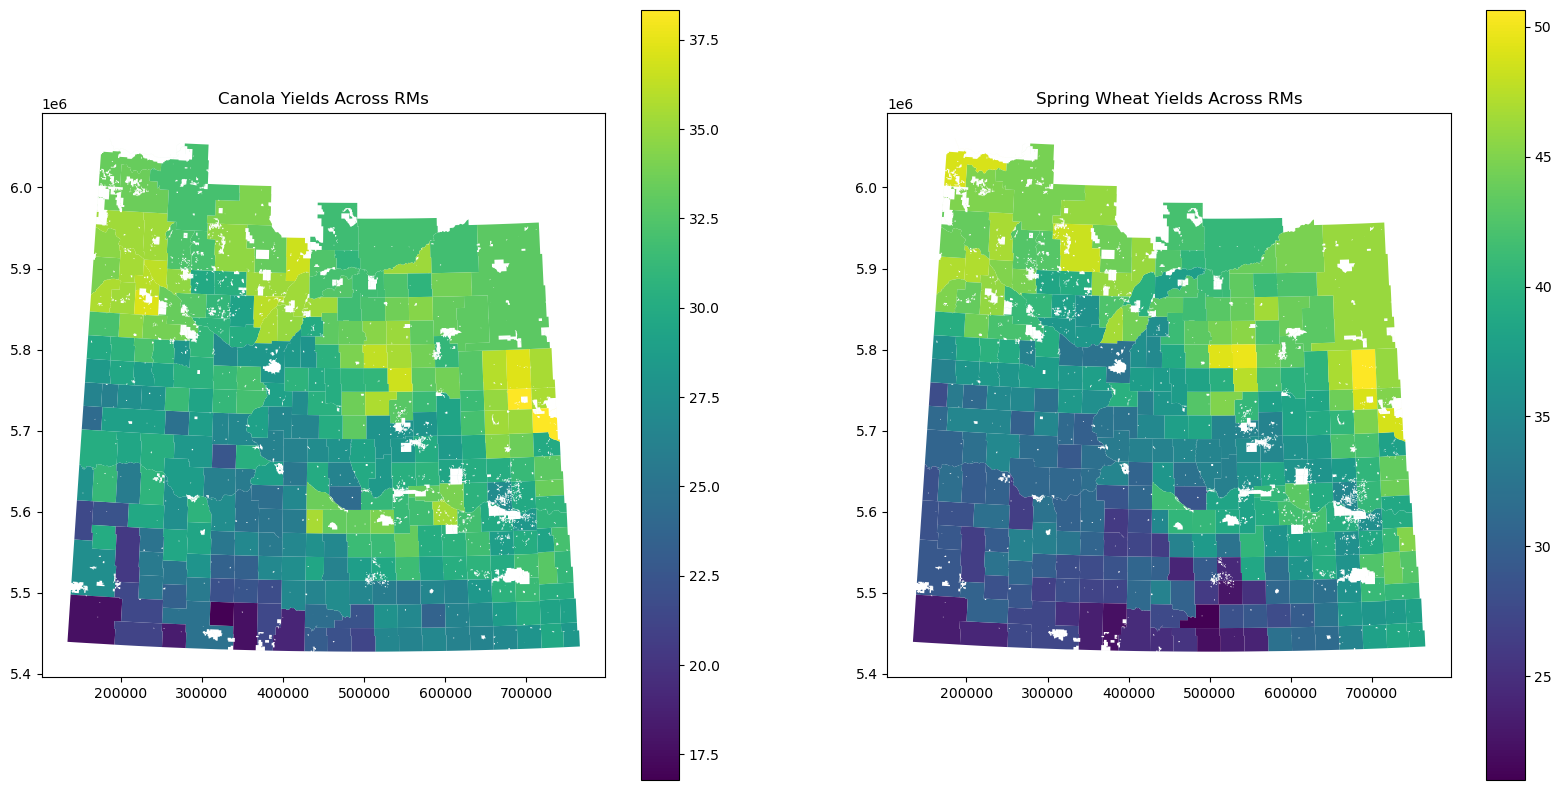

In [71]:
# Ensure 'Canola_mean' and 'Spring Wheat_mean' are numeric
gdf['Canola_mean'] = pd.to_numeric(gdf['Canola_mean'], errors='coerce')
gdf['Spring Wheat_mean'] = pd.to_numeric(gdf['Spring Wheat_mean'], errors='coerce')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Canola yields
gdf.plot(column='Canola_mean', cmap='viridis', legend=True, ax=axes[0])
axes[0].set_title('Canola Yields Across RMs')

# Plot Wheat yields
gdf.plot(column='Spring Wheat_mean', cmap='viridis', legend=True, ax=axes[1])
axes[1].set_title('Spring Wheat Yields Across RMs')

plt.show()



### Clustering Analysis Final


#### Spectral Clustering

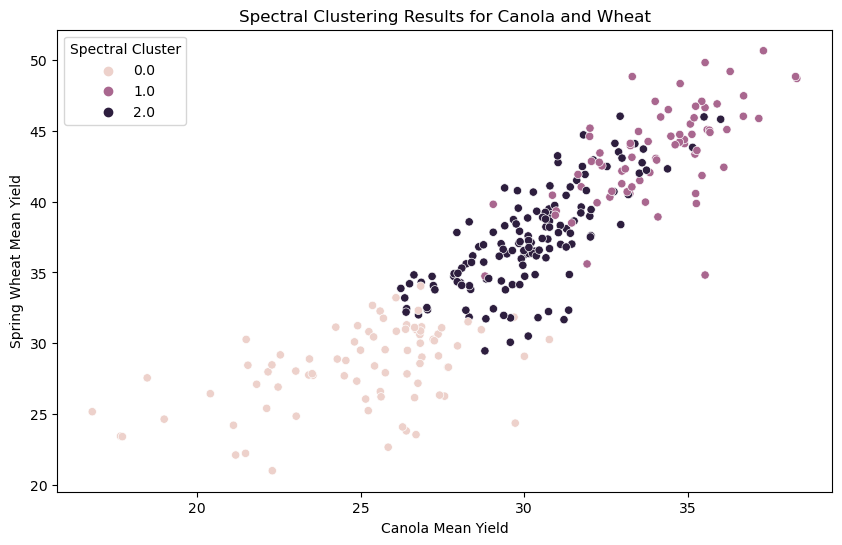

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Function to prepare data for clustering
def prepare_data_for_clustering(df, crops):
    columns = [f'{crop}_mean' for crop in crops] + [f'{crop}_std' for crop in crops]
    crop_data = df[columns].dropna().values
    return crop_data

# Standardize the data
def standardize_data(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

# Extract data for Canola and Wheat
crops = ['Canola', 'Spring Wheat']
crop_data = prepare_data_for_clustering(df_agg_00_23, crops)
crop_data_scaled = standardize_data(crop_data)

# Perform spectral clustering
spectral_clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0)
spectral_labels = spectral_clustering.fit_predict(crop_data_scaled)
df_agg_00_23['Spectral_Cluster'] = np.nan
df_agg_00_23.loc[~df_agg_00_23[[f'{crop}_mean' for crop in crops]].isna().any(axis=1), 'Spectral_Cluster'] = spectral_labels

# Visualize spectral clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_agg_00_23[f'{crops[0]}_mean'], y=df_agg_00_23[f'{crops[1]}_mean'], hue='Spectral_Cluster', data=df_agg_00_23)
plt.title('Spectral Clustering Results for Canola and Wheat')
plt.xlabel(f'{crops[0]} Mean Yield')
plt.ylabel(f'{crops[1]} Mean Yield')
plt.legend(title='Spectral Cluster')
plt.show()


### K-Means Clustering

c:\Users\muhammad.zeeshan\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\muhammad.zeeshan\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\muhammad.zeeshan\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\muhammad.zeeshan\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

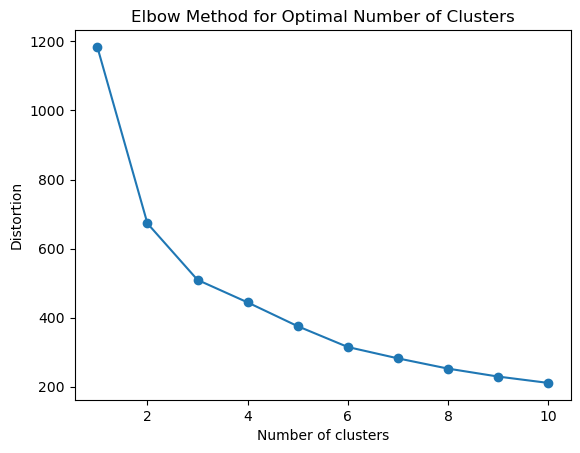

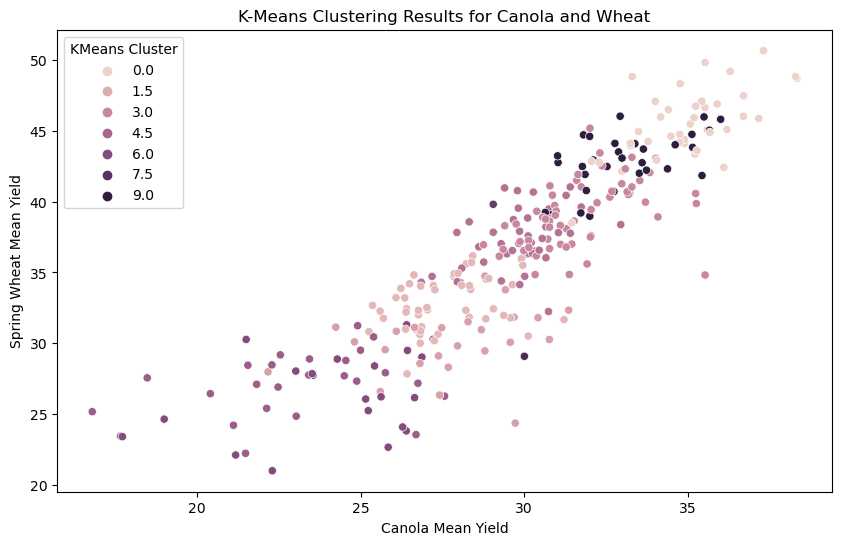

In [73]:
from sklearn.cluster import KMeans

# Function to find the optimal number of clusters using the Elbow method
def find_optimal_clusters_kmeans(data, max_k):
    distortions = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    optimal_k = distortions.index(min(distortions[1:])) + 1
    return optimal_k, distortions

# Find optimal number of clusters using the Elbow method
optimal_k, distortions = find_optimal_clusters_kmeans(crop_data_scaled, 10)

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_labels = kmeans.fit_predict(crop_data_scaled)
df_agg_00_23['KMeans_Cluster'] = np.nan
df_agg_00_23.loc[~df_agg_00_23[[f'{crop}_mean' for crop in crops]].isna().any(axis=1), 'KMeans_Cluster'] = kmeans_labels

# Plot the Elbow method graph
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Visualize K-Means clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_agg_00_23[f'{crops[0]}_mean'], y=df_agg_00_23[f'{crops[1]}_mean'], hue='KMeans_Cluster', data=df_agg_00_23)
plt.title('K-Means Clustering Results for Canola and Wheat')
plt.xlabel(f'{crops[0]} Mean Yield')
plt.ylabel(f'{crops[1]} Mean Yield')
plt.legend(title='KMeans Cluster')
plt.show()


## Part 2: Analysis of Crop Rotation Impact

###  Identifying Crop Rotation

In [74]:
# Identify RMs with crop rotation
rotation_df = df_agg_00_23.copy()
rotation_df['Crop_Rotation'] = np.where((rotation_df['Canola_mean'].notna() & rotation_df['Spring Wheat_mean'].notna()), 'Rotated', 'Not Rotated')

# Calculate yield differences
rotation_df['Yield_Difference'] = rotation_df['Canola_mean'] - rotation_df['Spring Wheat_mean']

# Check the rotation data
print(rotation_df.head())


  RM  Canola_mean  Canola_std  Spring Wheat_mean  Spring Wheat_std  \
0  1    28.314583    7.251919          38.569130          9.937700   
1  2    29.668750    5.456009          38.728261          8.209199   
2  3    27.938750    6.955191          37.818750          8.898998   
3  4    26.847917    6.624128          34.304583          8.999300   
4  5    26.401667    7.654146          31.305000          7.488937   

   Durum_mean  Durum_std  Oats_mean   Oats_std  Lentils_mean  Lentils_std  \
0   29.716000   5.769946  68.702917  21.210231     11.716667     0.589256   
1   36.761250  12.107829  65.697917  15.301719     18.819643     9.439195   
2   38.888750   8.297462  61.715417   9.990864     15.459217     7.746315   
3   34.329583  10.130348  53.237619  17.791265     21.702795     7.636129   
4   34.202083   9.808930  51.038462  15.160395     19.988108     5.764766   

   Peas_mean  Peas_std  Barley_mean  Barley_std  Spectral_Cluster  \
0  34.991667  9.203351    57.301739   18.607237

### Visualizing Crop Rotation Impact

<Figure size 1500x1000 with 0 Axes>

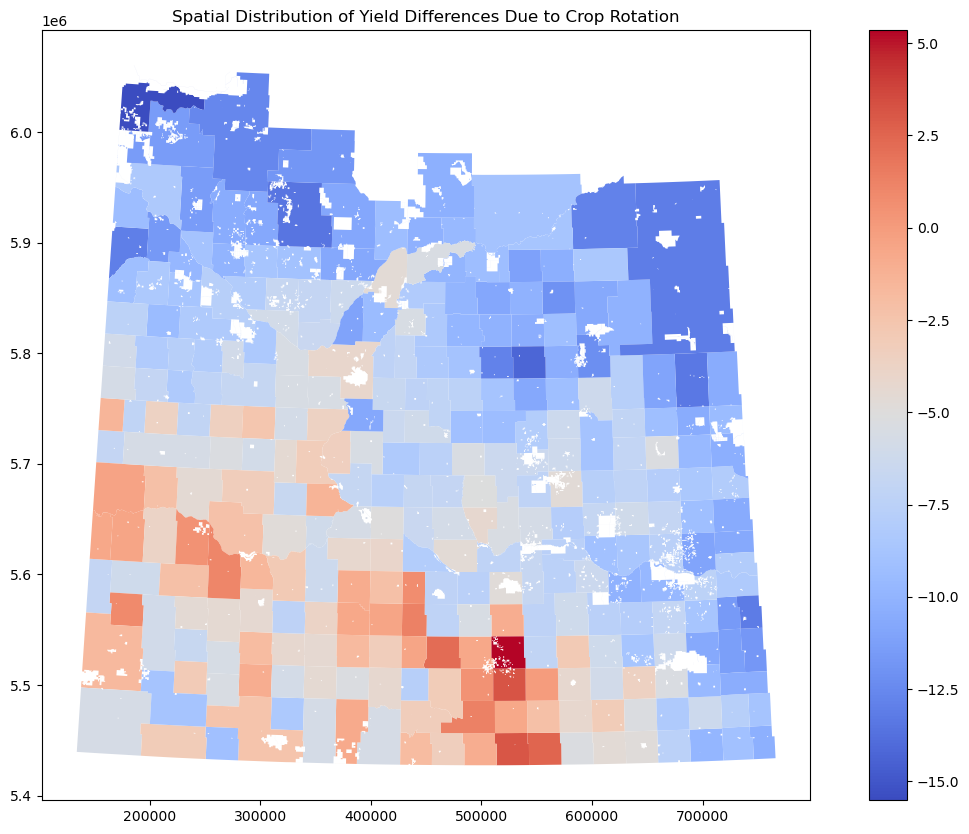

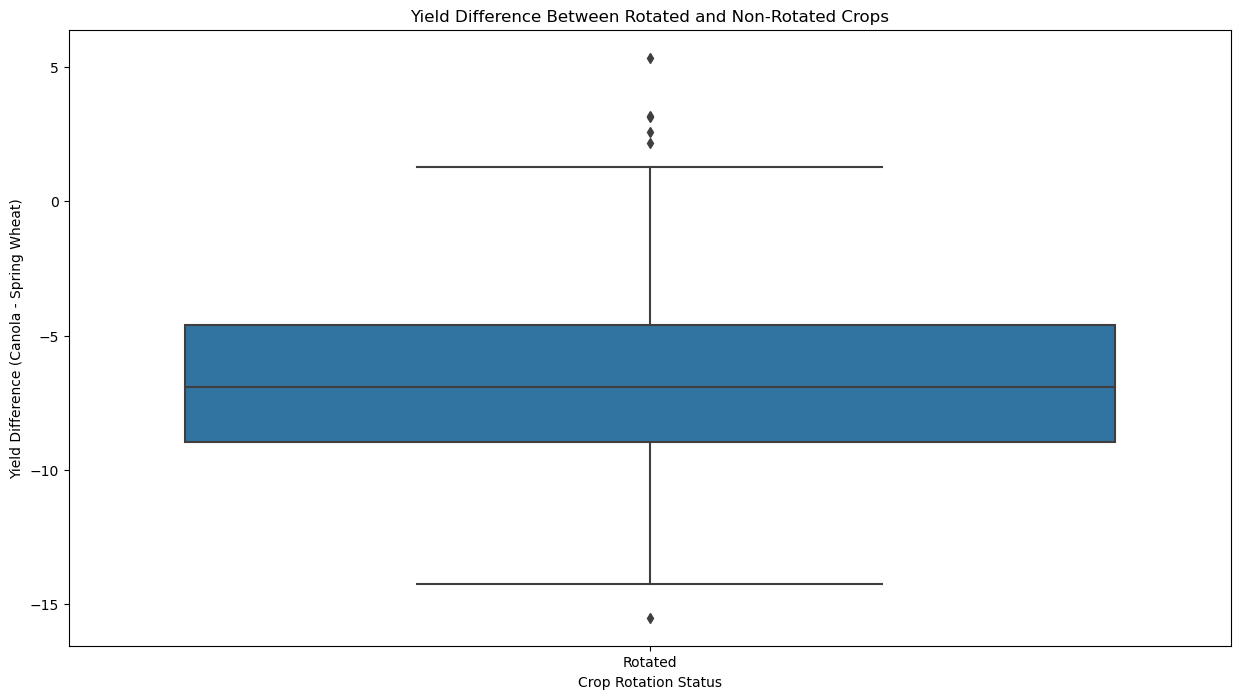

c:\Users\muhammad.zeeshan\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


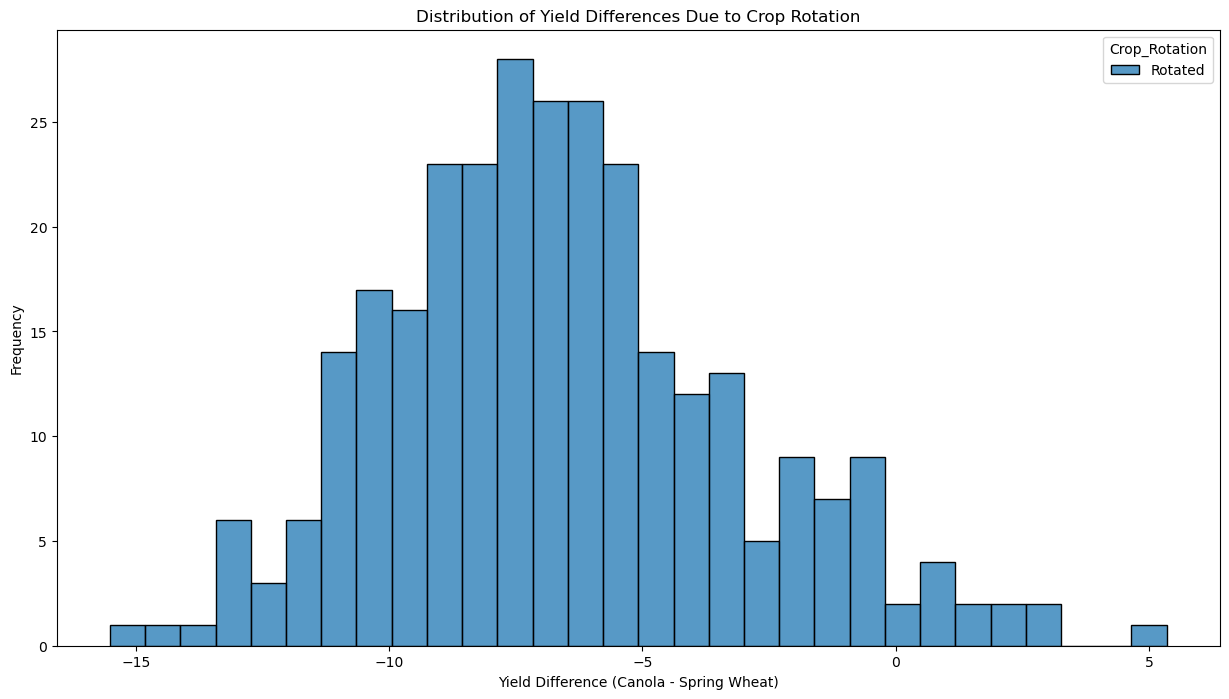

In [75]:
# Merge the rotation data with the GeoDataFrame
gdf = gdf.merge(rotation_df[['RM', 'Crop_Rotation', 'Yield_Difference']], on='RM', how='left')

# Plot spatial distribution of yield differences
plt.figure(figsize=(15, 10))
gdf.plot(column='Yield_Difference', cmap='coolwarm', legend=True, figsize=(15, 10))
plt.title('Spatial Distribution of Yield Differences Due to Crop Rotation')
plt.show()

# Box plot comparing yield differences for rotated and non-rotated crops
plt.figure(figsize=(15, 8))
sns.boxplot(x='Crop_Rotation', y='Yield_Difference', data=rotation_df)
plt.title('Yield Difference Between Rotated and Non-Rotated Crops')
plt.xlabel('Crop Rotation Status')
plt.ylabel('Yield Difference (Canola - Spring Wheat)')
plt.show()

# Histogram of yield differences
plt.figure(figsize=(15, 8))
sns.histplot(rotation_df, x='Yield_Difference', hue='Crop_Rotation', multiple='stack', bins=30)
plt.title('Distribution of Yield Differences Due to Crop Rotation')
plt.xlabel('Yield Difference (Canola - Spring Wheat)')
plt.ylabel('Frequency')
plt.show()


### Block 7: Analyzing Yield Improvement with Crop Rotation

['Rotated']
               Canola_mean  Spring Wheat_mean
Crop_Rotation                                
Rotated          29.726034          36.337641


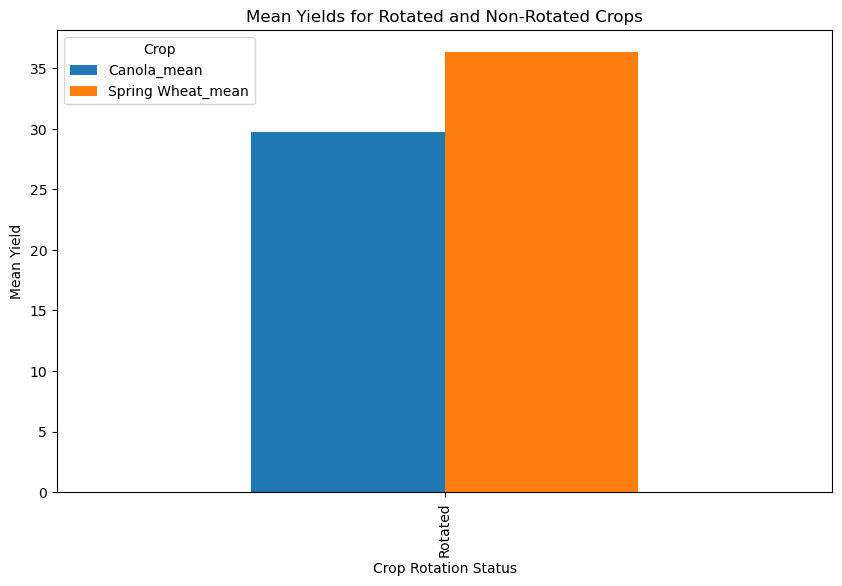

One of the categories ('Rotated' or 'Not Rotated') is missing in the data.


In [76]:
# Check unique values in Crop Rotation
print(rotation_df['Crop_Rotation'].unique())

# Calculate mean yield for rotated and non-rotated crops
mean_yields = rotation_df.groupby('Crop_Rotation')[['Canola_mean', 'Spring Wheat_mean']].mean()
print(mean_yields)

# Bar plot to compare mean yields for rotated and non-rotated crops
mean_yields.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Yields for Rotated and Non-Rotated Crops')
plt.xlabel('Crop Rotation Status')
plt.ylabel('Mean Yield')
plt.legend(title='Crop')
plt.show()

# Calculate percentage increase in yields for rotated crops
if 'Rotated' in mean_yields.index and 'Not Rotated' in mean_yields.index:
    rotation_effect = mean_yields.loc['Rotated'] / mean_yields.loc['Not Rotated'] - 1
    print(rotation_effect)

    # Bar plot to show percentage increase in yields due to crop rotation
    rotation_effect.plot(kind='bar', figsize=(10, 6))
    plt.title('Percentage Increase in Yields Due to Crop Rotation')
    plt.xlabel('Crop')
    plt.ylabel('Percentage Increase')
    plt.show()
else:
    print("One of the categories ('Rotated' or 'Not Rotated') is missing in the data.")


### Block 8: Cluster Analysis with Crop Rotation Impact

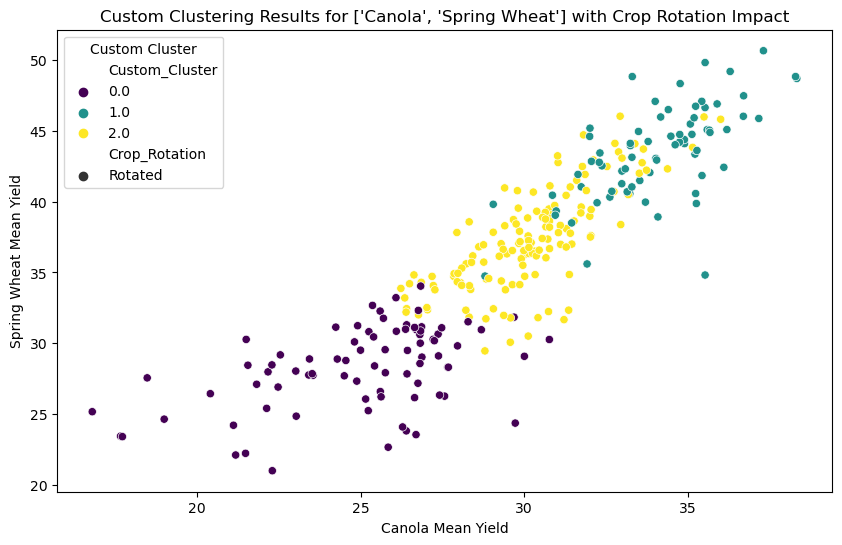

In [77]:
# Prepare data for clustering
def prepare_data_for_clustering_with_rotation(df, crops):
    columns = [f'{crop}_mean' for crop in crops] + [f'{crop}_std' for crop in crops]
    crop_data = df[columns].dropna().values
    indices = df.dropna(subset=columns).index
    return crop_data, indices

# Standardize the data
crop_data, indices = prepare_data_for_clustering_with_rotation(df_agg_00_23, crops)
crop_data_scaled = standardize_data(crop_data)

# Perform customized clustering
def perform_custom_clustering(data, n_clusters=3):
    clustering = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", random_state=0)
    labels = clustering.fit_predict(data)
    return labels

# Apply clustering
labels = perform_custom_clustering(crop_data_scaled, 3)
df_agg_00_23['Custom_Cluster'] = np.nan
df_agg_00_23.loc[indices, 'Custom_Cluster'] = labels

# Merge the crop rotation information
df_agg_00_23 = df_agg_00_23.merge(rotation_df[['RM', 'Crop_Rotation']], on='RM', how='left')

# Visualize custom clusters with crop rotation impact
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_agg_00_23.loc[indices, f'{crops[0]}_mean'], 
                y=df_agg_00_23.loc[indices, f'{crops[1]}_mean'], 
                hue=df_agg_00_23.loc[indices, 'Custom_Cluster'], 
                style=df_agg_00_23.loc[indices, 'Crop_Rotation'],
                palette='viridis')
plt.title(f'Custom Clustering Results for {crops} with Crop Rotation Impact')
plt.xlabel(f'{crops[0]} Mean Yield')
plt.ylabel(f'{crops[1]} Mean Yield')
plt.legend(title='Custom Cluster')
plt.show()
